In [234]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualisation
import matplotlib.pyplot as plt # data visualisation
import datetime as dt # working with time data
import plotly.graph_objs as go # plotly graphical object
import statsmodels.api as sm #time-series analysis for python
import warnings  
import missingno as msno 
warnings.filterwarnings('ignore')

In [235]:
df = pd.read_excel("../Data/gasoline_price_sentiment_pre-processed_7.xlsx", "Sheet1")
horizon = 7

# ARIMAX

In [236]:
buf = df.copy()#reset buf
buf = buf.set_index('Date')
buf.index = pd.DatetimeIndex(buf.index).to_period('D')

### Remove Any Final Missing Values

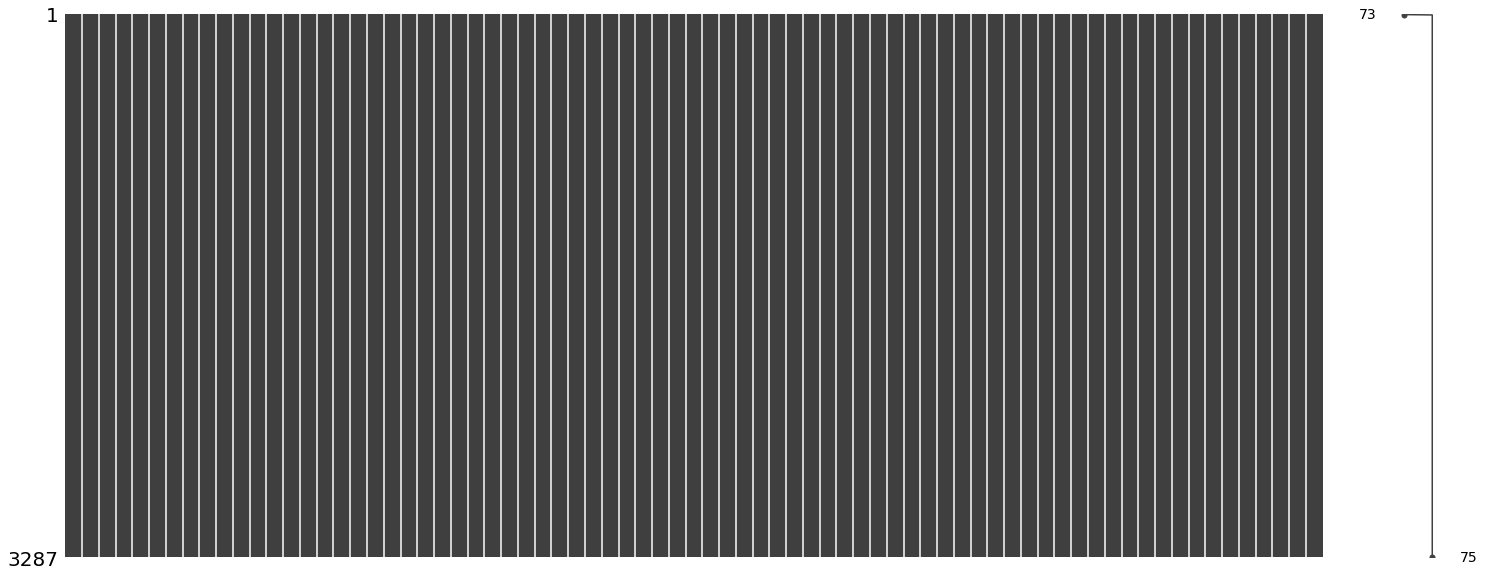

In [237]:
buf_before = buf.copy()
msno.matrix(buf_before)
plt.show()

In [238]:
def checkMissingVal(df):
    i = 0
    for val in buf.isna().sum():
        if(val > 0):
            print(f"Missing value detected in column {buf.columns[i]}")
        i+=1

In [239]:
checkMissingVal(buf)

Missing value detected in column price_lag_7
Missing value detected in column price_rm


### Select Features

In [240]:
buf.columns

Index(['Unnamed: 0', 'price', 'popularity', 'general_sentiment',
       'positive_outlook', 'happiness', 'bittersweet', 'confidence', 'disgust',
       'disagreement', 'anxiety', 'gloominess', 'distress', 'violent',
       'unexpectedness', 'timeliness', 'confusion', 'feelingsVsTruth',
       'buyVsSell', 'buyVsSellForecast', 'priceTrend', 'pricePrediction',
       'volatile', 'consumptionCommodity', 'productionCommodity', 'regulatory',
       'supplyDemandBalance', 'supplyDemandBalanceForecast', 'exploration',
       'accidents', 'National_Holiday', 'Weekend', 'Holidays', 'happiness_Log',
       'bittersweet_Log', 'disgust_Log', 'disagreement_Log', 'anxiety_Log',
       'gloominess_Log', 'distress_Log', 'violent_Log', 'unexpectedness_Log',
       'confusion_Log', 'buyVsSell_sqrt', 'pricePrediction_Log',
       'volatile_Log', 'productionCommodity_Log', 'regulatory_Log',
       'supplyDemandBalance_Log', 'exploration_Log', 'accidents_Log',
       'month-1', 'month-2', 'month-3', 'month

In [241]:
selected_variable_columns = ['price', 'happiness_Log', 'bittersweet_Log',
       'disgust_Log', 'disagreement_Log', 'anxiety_Log', 'gloominess_Log',
       'distress_Log', 'violent_Log', 'unexpectedness_Log', 'confusion_Log',
       'buyVsSell_sqrt', 'pricePrediction_Log', 'volatile_Log',
       'productionCommodity_Log', 'regulatory_Log', 'supplyDemandBalance_Log',
       'exploration_Log', 'accidents_Log', 'supplyDemandBalanceForecast', 
       'consumptionCommodity', 'priceTrend', 'buyVsSellForecast', 'feelingsVsTruth',
       'timeliness', 'confidence', 'popularity', 'general_sentiment', 'positive_outlook',
       'price_lag_7', 'month-1', 'month-2', 
       'month-3', 'month-4', 'month-5', 'month-6', 'month-7', 'month-8', 
       'month-9', 'month-10', 'month-11', 'month-12', 'dayofweek-0',
       'dayofweek-1', 'dayofweek-2', 'dayofweek-3', 'dayofweek-4',
       'dayofweek-5', 'dayofweek-6', 'weekend', 'sunday']

#We are taking the transformed columns and the derived features

## Train Test Split

In [242]:
train_size = int(len(buf) * 0.80)
train_size

2629

In [243]:
buf_test = buf.copy()
buf_test.reset_index(inplace=True)
tr_start = str(buf_test.iloc[0].Date.to_timestamp(freq='D'))[:10]
tr_end = str(buf_test.iloc[train_size].Date.to_timestamp(freq='D'))[:10]
te_start = str(buf_test.iloc[train_size+1].Date.to_timestamp(freq='D'))[:10]
te_end = str(buf_test.iloc[-1].Date.to_timestamp(freq='D'))[:10]

Since the end of train set date is almost close to end of March, we will just take until the end of that month (31st March) so that it is including the whole first quarter of the year.

In [244]:
tr_end = '2017-03-31'
te_start = '2017-04-01'

In [245]:
tr_start = '2010-01-08' #To remove the lagged rows with NA values

In [246]:
tr_start, tr_end, te_start, te_end

('2010-01-08', '2017-03-31', '2017-04-01', '2018-12-31')

In [247]:
buf = buf.loc[:, selected_variable_columns]
exog_features = buf.drop(axis=1, columns='price').columns #to predict first week
exog_features

Index(['happiness_Log', 'bittersweet_Log', 'disgust_Log', 'disagreement_Log',
       'anxiety_Log', 'gloominess_Log', 'distress_Log', 'violent_Log',
       'unexpectedness_Log', 'confusion_Log', 'buyVsSell_sqrt',
       'pricePrediction_Log', 'volatile_Log', 'productionCommodity_Log',
       'regulatory_Log', 'supplyDemandBalance_Log', 'exploration_Log',
       'accidents_Log', 'supplyDemandBalanceForecast', 'consumptionCommodity',
       'priceTrend', 'buyVsSellForecast', 'feelingsVsTruth', 'timeliness',
       'confidence', 'popularity', 'general_sentiment', 'positive_outlook',
       'price_lag_7', 'month-1', 'month-2', 'month-3', 'month-4', 'month-5',
       'month-6', 'month-7', 'month-8', 'month-9', 'month-10', 'month-11',
       'month-12', 'dayofweek-0', 'dayofweek-1', 'dayofweek-2', 'dayofweek-3',
       'dayofweek-4', 'dayofweek-5', 'dayofweek-6', 'weekend', 'sunday'],
      dtype='object')

In [248]:
tra = buf[tr_start:tr_end].loc[:, 'price']
tes = buf[te_start:te_end].loc[:, 'price']
exog_train = buf[tr_start:tr_end].loc[:, exog_features]
exog_test = buf[te_start:te_end].loc[:, exog_features]

In [249]:
checkMissingVal(tes) #Ensure all the values being passed to ARIMAX are not null

Missing value detected in column price_lag_7


In [250]:
from datetime import timedelta, date
horizon = 7

test_horizon_slices = []
i = 0
cnt = 0
for row in tes.rolling(window=7).mean().index:

    if i % horizon > 0:
        i+=1
        continue
    
    cnt +=1
    start = row
    end = row + timedelta(horizon) - 1
    startStr = str(start.to_timestamp(freq='D'))[:10]
    endStr = str(end.to_timestamp(freq='D'))[:10]
    test_horizon_slices.append((startStr, endStr))
    i+=1

# print(cnt)
# test_horizon_slices[:-1]

### Train The Model

Baseline

In [254]:
import statsmodels.api as sm #time-series analysis for python

arimax = sm.tsa.statespace.SARIMAX(tra,order=(1,0,1),seasonal_order=(0,0,0,0),exog = exog_train, freq='D',
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
arimax.summary()
#We can use SARIMAX model as ARIMAX when seasonal_order is (0,0,0,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                 2640
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -5409.140
Date:                Wed, 10 Aug 2022   AIC                          10924.280
Time:                        15:06:45   BIC                          11235.802
Sample:                    01-08-2010   HQIC                         11037.069
                         - 03-31-2017                                         
Covariance Type:                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
happiness_Log                   6.8180     10.671      0.639      0.523     -14.097      27.733
bittersweet_Log                 9.9593     10.027      0.993      0.321      -9.693      29.612
disgust_Log                    11.2544      7.468      1.507      0.132      -3.382      25.891
disagreement_Log               -5.6049      1.962     -2.857      0.004      -9.450      -1.760
anxiety_Log                    16.0652      6.167      2.605      0.009       3.979      28.152
gloominess_Log                 -5.4296      2.824     -1.923      0.054     -10.964       0.105
distress_Log                    7.0401      2.438      2.888      0.004       2.263      11.818
violent_Log                     4.7138      1.672      2.819      0.005       1.436       7.991
unexpectedness_Log             20.7752      6.172      3.366      0.001       8.679      32.871
confusion_Log                  13.1904      4.467      2.953      0.003       4.434      21.946
buyVsSell_sqrt                 28.6883      8.487      3.380      0.001      12.053      45.323
pricePrediction_Log            36.2900      5.705      6.361      0.000      25.107      47.472
volatile_Log                    3.6858      2.646      1.393      0.164      -1.501       8.873
productionCommodity_Log        -1.1640      4.238     -0.275      0.784      -9.471       7.143
regulatory_Log                 57.5013     11.118      5.172      0.000      35.711      79.292
supplyDemandBalance_Log        -5.5829      0.720     -7.758      0.000      -6.993      -4.173
exploration_Log               -61.1171     21.112     -2.895      0.004    -102.495     -19.739
accidents_Log                 -37.6504     16.131     -2.334      0.020     -69.266      -6.035
supplyDemandBalanceForecast    -8.5816      3.394     -2.529      0.011     -15.233      -1.930
consumptionCommodity           -6.4691      7.063     -0.916      0.360     -20.312       7.374
priceTrend                     15.8746      1.937      8.195      0.000      12.078      19.671
buyVsSellForecast             -21.5008     12.464     -1.725      0.085     -45.931       2.929
feelingsVsTruth                -0.1484      0.539     -0.275      0.783      -1.205       0.909
timeliness                     -9.1035      2.099     -4.336      0.000     -13.218      -4.989
confidence                    -10.5887      6.829     -1.550      0.121     -23.974       2.796
popularity                  -1.733e-06   2.19e-05     -0.079      0.937   -4.46e-05    4.11e-05
general_sentiment               3.7484      0.637      5.887      0.000       2.501       4.996
positive_outlook               -4.7500      1.546     -3.073      0.002      -7.780      -1.720
price_lag_7                     0.9818      0.008    116.649      0.000       0.965       0.998
month-1                         4.2999      5.141      0.836      0.403      -5.776      14.376
month-2                         5.5534      5.110      1.087      0.277  

From PMD Auto-Arima

In [252]:
# import pmdarima as pm
# arimaxAuto = pm.auto_arima(tra, X=exog_train, start_p=1, start_q=1,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=3, max_q=3, # maximum p and q
#                       m=7,              # frequency of series
#                       d=1,           # let model determine 'd'
#                       seasonal=False,   # No Seasonality
#                       start_P=0, 
#                       D=0, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True)
# arimaxAuto.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8961.818, Time=6.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8957.901, Time=7.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8959.783, Time=7.24 sec


KeyboardInterrupt: 

In [260]:
tra.index = tra.index.to_timestamp(freq='D')
exog_train.index = exog_train.index.to_timestamp(freq='D')

In [261]:
import statsmodels.api as sm #time-series analysis for python

arimaxAuto = sm.tsa.statespace.SARIMAX(tra,order=(1,1,1),seasonal_order=(0,0,0,0),exog = exog_train, freq='D',
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
arimaxAuto.summary()
#We can use SARIMAX model as ARIMAX when seasonal_order is (0,0,0,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                 2640
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4424.440
Date:                Wed, 10 Aug 2022   AIC                           8954.880
Time:                        15:08:21   BIC                           9266.382
Sample:                    01-08-2010   HQIC                          9067.664
                         - 03-31-2017                                         
Covariance Type:                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
happiness_Log                  -3.5315      7.303     -0.484      0.629     -17.845      10.782
bittersweet_Log                -2.5417      6.774     -0.375      0.708     -15.819      10.736
disgust_Log                     8.3547      4.987      1.675      0.094      -1.419      18.128
disagreement_Log               -0.3402      1.351     -0.252      0.801      -2.988       2.307
anxiety_Log                     5.1473      3.918      1.314      0.189      -2.533      12.827
gloominess_Log                 -0.5449      1.929     -0.282      0.778      -4.326       3.236
distress_Log                    1.4476      1.653      0.875      0.381      -1.793       4.688
violent_Log                    -0.4051      1.104     -0.367      0.714      -2.568       1.758
unexpectedness_Log              8.7172      3.971      2.195      0.028       0.934      16.500
confusion_Log                   3.6748      2.936      1.252      0.211      -2.080       9.429
buyVsSell_sqrt                  7.6149      6.205      1.227      0.220      -4.547      19.777
pricePrediction_Log             0.0968      4.718      0.021      0.984      -9.150       9.344
volatile_Log                   -0.3289      1.779     -0.185      0.853      -3.816       3.158
productionCommodity_Log         1.0442      2.931      0.356      0.722      -4.701       6.790
regulatory_Log                  3.9093     12.315      0.317      0.751     -20.227      28.045
supplyDemandBalance_Log        -0.8786      0.450     -1.954      0.051      -1.760       0.003
exploration_Log               -32.0177     16.129     -1.985      0.047     -63.631      -0.405
accidents_Log                  17.1822     10.841      1.585      0.113      -4.066      38.431
supplyDemandBalanceForecast    -0.1397      2.206     -0.063      0.949      -4.463       4.184
consumptionCommodity           -1.9579      4.742     -0.413      0.680     -11.252       7.336
priceTrend                      1.8262      1.392      1.312      0.190      -0.903       4.555
buyVsSellForecast              -6.6091      8.410     -0.786      0.432     -23.092       9.873
feelingsVsTruth                -0.1426      0.354     -0.403      0.687      -0.836       0.551
timeliness                     -3.1638      1.487     -2.128      0.033      -6.078      -0.250
confidence                      3.8142      4.944      0.772      0.440      -5.875      13.503
popularity                  -2.093e-05   1.36e-05     -1.537      0.124   -4.76e-05    5.76e-06
general_sentiment               1.0904      0.423      2.575      0.010       0.260       1.920
positive_outlook               -1.4684      1.067     -1.376      0.169      -3.560       0.623
price_lag_7                     0.0496      0.016      3.028      0.002       0.017       0.082
month-1                        -0.4420      1.562     -0.283      0.777      -3.503       2.619
month-2                        -0.0206      1.514     -0.014      0.989  

Transform the Price to Price_Log So That The Multiplicative Variable is More Compatible with the Additive ARIMAX Method

In [263]:
traLog = np.log(tra)

From PMD Auto-Arima on Price_Log

In [267]:
import pmdarima as pm
arimaxAutoLog = pm.auto_arima(traLog, X=exog_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=7,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
arimaxAutoLog.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14534.090, Time=8.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14538.239, Time=6.69 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14536.424, Time=6.88 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14536.431, Time=8.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3612.370, Time=4.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 34.922 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2640
Model:               SARIMAX(0, 1, 0)   Log Likelihood                7321.119
Date:                Wed, 10 Aug 2022   AIC                         -14538.239
Time:                        15:10:36   BIC                         -14232.575
Sample:                    01-08-2010   HQIC                        -14427.573
                         - 03-31-2017                                         
Covariance Type:                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
intercept                      -0.0001      0.001     -0.104      0.917      -0.002       0.002
happiness_Log                  -0.0169      0.078     -0.217      0.828      -0.170       0.136
bittersweet_Log                -0.0469      0.077     -0.609      0.543      -0.198       0.104
disgust_Log                     0.0909      0.060      1.516      0.129      -0.027       0.208
disagreement_Log               -0.0076      0.015     -0.508      0.611      -0.037       0.022
anxiety_Log                     0.0404      0.046      0.876      0.381      -0.050       0.131
gloominess_Log                 -0.0056      0.023     -0.244      0.807      -0.051       0.039
distress_Log                    0.0147      0.018      0.804      0.422      -0.021       0.051
violent_Log                    -0.0034      0.013     -0.261      0.794      -0.029       0.022
unexpectedness_Log              0.0948      0.046      2.043      0.041       0.004       0.186
confusion_Log                   0.0464      0.034      1.370      0.171      -0.020       0.113
buyVsSell_sqrt                  0.0780      0.071      1.100      0.271      -0.061       0.217
pricePrediction_Log            -0.0172      0.054     -0.318      0.751      -0.123       0.089
volatile_Log                   -0.0064      0.022     -0.291      0.771      -0.049       0.036
productionCommodity_Log         0.0173      0.032      0.539      0.590      -0.046       0.080
regulatory_Log                  0.0116      0.149      0.078      0.938      -0.280       0.303
supplyDemandBalance_Log        -0.0076      0.005     -1.405      0.160      -0.018       0.003
exploration_Log                -0.3286      0.192     -1.714      0.086      -0.704       0.047
accidents_Log                   0.1832      0.146      1.254      0.210      -0.103       0.469
supplyDemandBalanceForecast    -0.0075      0.025     -0.303      0.762      -0.056       0.041
consumptionCommodity           -0.0350      0.050     -0.700      0.484      -0.133       0.063
priceTrend                      0.0174      0.017      1.023      0.306      -0.016       0.051
buyVsSellForecast              -0.0840      0.098     -0.858      0.391      -0.276       0.108
feelingsVsTruth                -0.0013      0.004     -0.341      0.733      -0.009       0.006
timeliness                     -0.0364      0.018     -2.064      0.039      -0.071      -0.002
confidence                      0.0491      0.051      0.956      0.339      -0.051       0.150
popularity                  -1.883e-07   1.74e-07     -1.083      0.279   -5.29e-07    1.52e-07
general_sentiment               0.0097      0.005      2.024      0.043       0.000       0.019
positive_outlook               -0.0164      0.012     -1.371      0.170      -0.040       0.007
price_lag_7                     0.0006      0.000      3.123      0.002       0.000       0.001
month-1                        -0.0025      0.018     -0.134      0.894  

In [293]:
import statsmodels.api as sm #time-series analysis for python

arimaxAutoLog = sm.tsa.statespace.SARIMAX(traLog,order=(1,1,1),seasonal_order=(0,0,0,0),exog = exog_train, freq='D',
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
arimaxAutoLog.summary()
#We can use SARIMAX model as ARIMAX when seasonal_order is (0,0,0,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                 2640
Model:               SARIMAX(1, 1, 1)   Log Likelihood                7314.543
Date:                Wed, 10 Aug 2022   AIC                         -14523.086
Time:                        15:18:48   BIC                         -14211.584
Sample:                    01-08-2010   HQIC                        -14410.302
                         - 03-31-2017                                         
Covariance Type:                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
happiness_Log                  -0.0169      0.079     -0.214      0.830      -0.172       0.138
bittersweet_Log                -0.0469      0.078     -0.604      0.546      -0.199       0.105
disgust_Log                     0.0909      0.060      1.505      0.132      -0.028       0.209
disagreement_Log               -0.0076      0.015     -0.500      0.617      -0.038       0.022
anxiety_Log                     0.0404      0.046      0.871      0.384      -0.050       0.131
gloominess_Log                 -0.0056      0.023     -0.241      0.809      -0.051       0.040
distress_Log                    0.0147      0.019      0.796      0.426      -0.022       0.051
violent_Log                    -0.0034      0.013     -0.258      0.796      -0.029       0.022
unexpectedness_Log              0.0948      0.047      2.025      0.043       0.003       0.187
confusion_Log                   0.0464      0.034      1.358      0.175      -0.021       0.113
buyVsSell_sqrt                  0.0780      0.072      1.084      0.278      -0.063       0.219
pricePrediction_Log            -0.0172      0.054     -0.315      0.753      -0.124       0.090
volatile_Log                   -0.0064      0.022     -0.290      0.772      -0.049       0.037
productionCommodity_Log         0.0173      0.032      0.536      0.592      -0.046       0.081
regulatory_Log                  0.0116      0.150      0.077      0.939      -0.283       0.306
supplyDemandBalance_Log        -0.0076      0.005     -1.397      0.163      -0.018       0.003
exploration_Log                -0.3286      0.193     -1.703      0.088      -0.707       0.049
accidents_Log                   0.1832      0.146      1.253      0.210      -0.103       0.470
supplyDemandBalanceForecast    -0.0075      0.025     -0.302      0.763      -0.056       0.041
consumptionCommodity           -0.0350      0.050     -0.696      0.486      -0.133       0.063
priceTrend                      0.0174      0.017      1.018      0.309      -0.016       0.051
buyVsSellForecast              -0.0840      0.099     -0.852      0.394      -0.277       0.109
feelingsVsTruth                -0.0013      0.004     -0.337      0.736      -0.009       0.006
timeliness                     -0.0364      0.018     -2.049      0.040      -0.071      -0.002
confidence                      0.0491      0.052      0.946      0.344      -0.053       0.151
popularity                  -1.883e-07   1.74e-07     -1.081      0.279    -5.3e-07    1.53e-07
general_sentiment               0.0097      0.005      2.011      0.044       0.000       0.019
positive_outlook               -0.0164      0.012     -1.363      0.173      -0.040       0.007
price_lag_7                     0.0006      0.000      3.107      0.002       0.000       0.001
month-1                        -0.0025      0.019     -0.131      0.895      -0.039       0.034
month-2                         0.0009      0.018      0.047      0.962  

### Evaluate the performance between the same algorithm with slightly different hyperparameters

ARIMAX Baseline

In [273]:
res = arimax.resid
sumOfSquares = 0
for r in res:
    sumOfSquares += r**2

mse_train = sumOfSquares / len(res)
print('ARIMAX baseline model MSE for training: {}'.format(mse_train))

from sklearn.metrics import mean_squared_error

st = str(exog_test.reset_index().iloc[0, 0])[:10]
en = str(exog_test.reset_index().iloc[-1, 0])[:10]

pred_train = arimax.fittedvalues
pred_train.index = pred_train.index.to_timestamp()
pred = arimax.predict(st, en, exog = exog_test)
print('ARIMAX model MSE:{}'.format(mean_squared_error(tes,pred)))

ARIMAX baseline model MSE for training: 3.545493106631011
ARIMAX model MSE:5.658751526542011


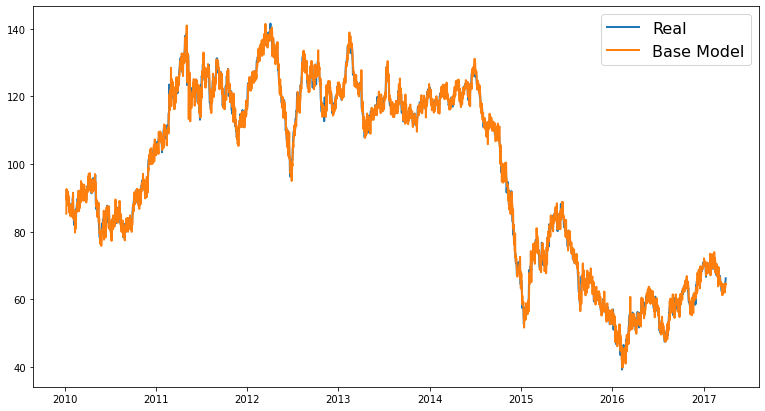

In [274]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(tra, label='Real', linewidth=2)
ax.plot(pred_train, label='Base Model', linewidth=2)
ax.legend(loc='best', fontsize=16)

In [277]:
tes.index = tes.index.to_timestamp(freq='D')

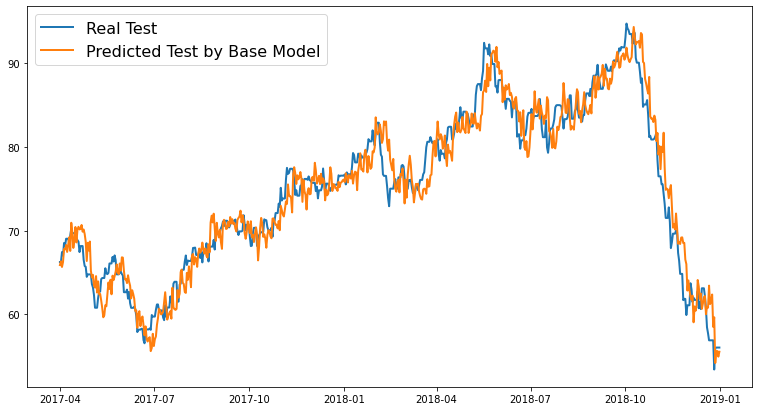

In [279]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(tes, label='Real Test', linewidth=2)
ax.plot(pred, label='Predicted Test by Base Model', linewidth=2)
ax.legend(loc='best', fontsize=16)

In [280]:
from sklearn.metrics import mean_squared_error

st = str(exog_train.reset_index().iloc[0, 0])[:10]
en = str(exog_train.reset_index().iloc[-1, 0])[:10]

pred_train = arimax.fittedvalues
print('ARIMAX model MSE:{}'.format(mean_squared_error(tra,pred_train)))

ARIMAX model MSE:3.5454931066310094


Auto ARIMAX

In [286]:
res = arimaxAuto.resid
sumOfSquares = 0
for r in res:
    sumOfSquares += r**2

mse_train = sumOfSquares / len(res)
print('ARIMAX baseline model MSE for training: {}'.format(mse_train))

from sklearn.metrics import mean_squared_error

st = str(exog_test.reset_index().iloc[0, 0])[:10]
en = str(exog_test.reset_index().iloc[-1, 0])[:10]

pred_train = arimaxAuto.fittedvalues
pred = arimaxAuto.predict(st, en, exog = exog_test)
print('ARIMAX model MSE:{}'.format(mean_squared_error(tes,pred)))

ARIMAX baseline model MSE for training: 4.5450856129313735
ARIMAX model MSE:149.5412058139596


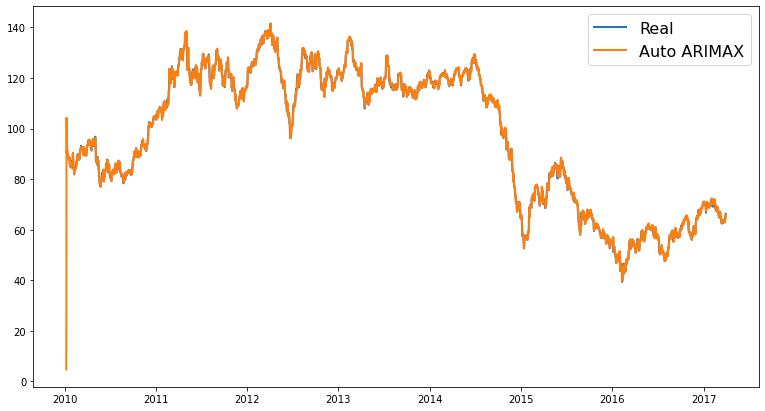

In [287]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(tra, label='Real', linewidth=2)
ax.plot(pred_train, label='Auto ARIMAX', linewidth=2)
ax.legend(loc='best', fontsize=16)

Auto ARIMAX for Price Log

In [297]:
res = arimaxAutoLog.resid
sumOfSquares = 0
for r in res:
    sumOfSquares += r**2

mse_train = sumOfSquares / len(res)
print('ARIMAX baseline model MSE for training: {}'.format(mse_train))

from sklearn.metrics import mean_squared_error

st = str(exog_test.reset_index().iloc[0, 0])[:10]
en = str(exog_test.reset_index().iloc[-1, 0])[:10]

pred_train = arimaxAutoLog.fittedvalues
pred = arimaxAutoLog.predict(st, en, exog = exog_test)
pred = np.exp(pred)
print('ARIMAX model MSE:{}'.format(mean_squared_error(tes,pred)))

ARIMAX baseline model MSE for training: 0.007961174274846725
ARIMAX model MSE:157.64244800368525


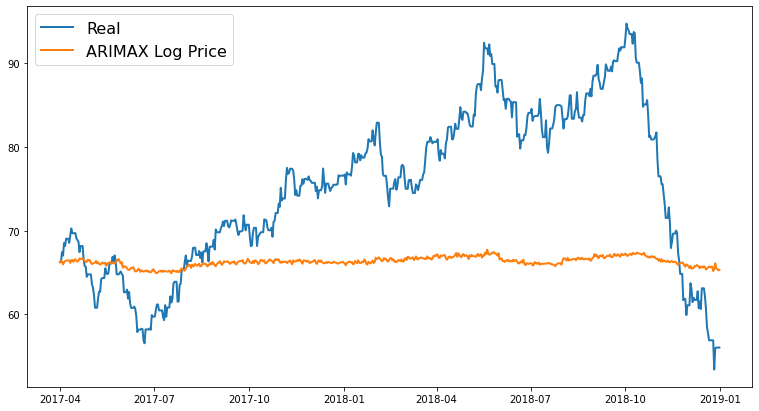

In [295]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(tes, label='Real', linewidth=2)
ax.plot(pred, label='ARIMAX Log Price', linewidth=2)
ax.legend(loc='best', fontsize=16)

Plot Test vs Pred

In [304]:
tesPlt = tes.copy()
predPlt = pred.copy()
predAutoPlt = predAuto.copy()
predAuto2Plt = predAuto2.copy()

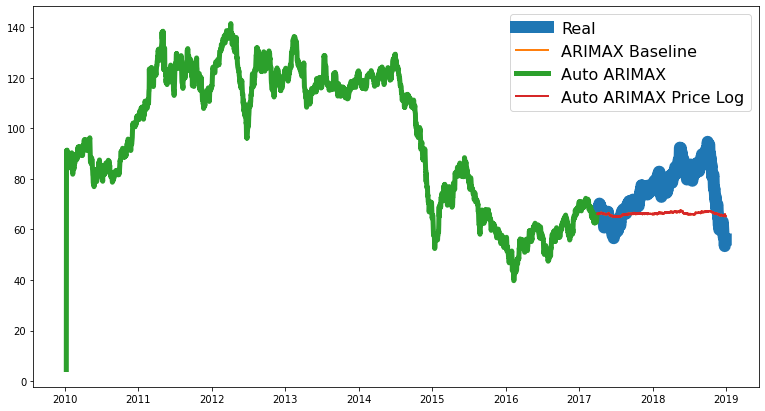

In [305]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(tesPlt, label='Real', linewidth=12)
ax.plot(predPlt, label='ARIMAX Baseline', linewidth=2)
ax.plot(predAutoPlt, label='Auto ARIMAX', linewidth=5)
ax.plot(predAuto2Plt, label='Auto ARIMAX Price Log', linewidth=2)
ax.legend(loc='best', fontsize=16)

### Output the model to a pickle file for comparison with other models

In [309]:
import pickle
path = "../Models/"
filename = "arimax.sav" #change according to your model name
filepath = path + filename
pickle.dump(arimax, open(filepath, 'wb'))